In [8]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import xgboost as xgb


In [ ]:

def generate_data(n, gamma):  # Pour la reproductibilité

    # Paramètres
    mean1 = [0, 0]
    mean2a = [0, 1]
    gamma_rad = np.deg2rad(gamma)
    mean2b = [np.cos(gamma_rad), np.sin(gamma_rad)]
    cov = np.diag([0.2, 0.2])  # Covariance matrix
    
    # Nombre d'échantillons pour chaque classe
    n_class = n // 2
    
    # Génération des données pour la classe 1
    class1 = np.random.multivariate_normal(mean1, cov, n_class)
    
    # Génération des données pour la classe 2
    class2a = np.random.multivariate_normal(mean2a, cov, n_class // 2)
    class2b = np.random.multivariate_normal(mean2b, cov, n_class // 2)
    class2 = np.vstack((class2a, class2b))
    
    # Création des étiquettes
    labels_class1 = np.zeros(n_class)
    labels_class2 = np.ones(n_class)
    
    # Combiner les données
    X = np.vstack((class1, class2))
    y = np.hstack((labels_class1, labels_class2))
    
    return X, y


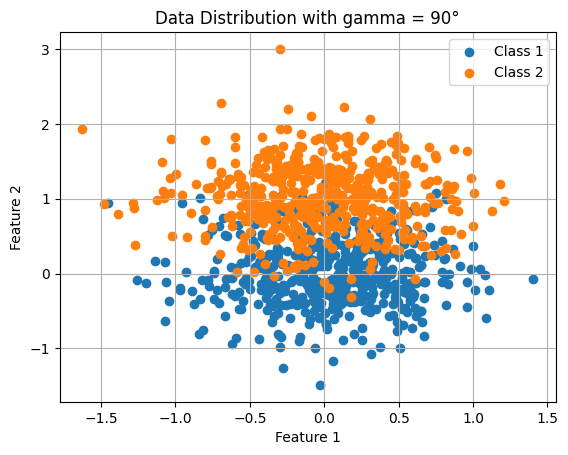

In [16]:

# Exemple d'utilisation
n = 1000
gamma = 90  # Par exemple
X, y = generate_data(n, gamma)

# Visualisation
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], label='Class 1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Class 2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title(f'Data Distribution with gamma = {gamma}°')
plt.grid(True)
plt.show()


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Analyse Discriminante Linéaire (LDA)
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)
y_pred_lda = lda_classifier.predict(X_test)
accuracy_lda = accuracy_score(y_test, y_pred_lda)

In [18]:

# Afficher les résultats
print(f"Accuracy of XGBoost: {accuracy_xgb:.2f}")
print(f"Accuracy of Linear Discriminant Analysis: {accuracy_lda:.2f}")


Accuracy of XGBoost: 0.87
Accuracy of Linear Discriminant Analysis: 0.88


In [ ]:

# Visualisation des frontières de décision
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)

# Tracer les frontières de décision
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(xgb_classifier, X_test, y_test, 'XGBoost Classifier')
plt.subplot(1, 2, 2)
plot_decision_boundary(lda_classifier, X_test, y_test, 'Linear Discriminant Analysis')
plt.show()